In [1]:
from pyspark.streaming import StreamingContext
from pyspark import SparkConf, SparkContext
from pyspark.streaming import StreamingContext
import json
import time
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import explode
from kafka import KafkaConsumer

#### On importe la session grace à laquelle on va load nos modeles et nos pipelines de prepro

In [2]:

from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .master('local[*]') \
    .config("spark.driver.memory", "5g") \
    .appName('app') \
    .getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
from pyspark.ml.classification import LogisticRegressionModel

###### load des  4 modeles entrainés

In [4]:
path1=("model_l1_p1")

In [5]:
path2=("model_l1_pp2")

In [6]:
path3=("model_l2_p1")

In [7]:
path4=("model_l2_p2")

In [8]:
model_l1_p1=LogisticRegressionModel.load(path1)

In [9]:
model_l1_p2=LogisticRegressionModel.load(path2)

In [12]:
model_l2_p1=LogisticRegressionModel.load(path3)

In [13]:
model_l2_p2=LogisticRegressionModel.load(path4)

In [14]:
from pyspark.ml import PipelineModel



#### On importe nos pipelines de prepro pour faire fonctionner les modeles

In [15]:
path1=("model_pipel1p1")

In [16]:
path2=("model_pipel1pp2")

In [17]:
path3=("model_pipel2p1")

In [18]:
path4=("model_pipel2p2")

In [19]:
pipel1p1=PipelineModel.load(path1)

In [20]:
pipel1p2=PipelineModel.load(path2)

In [21]:
pipel2p1=PipelineModel.load(path3)

In [22]:
pipel2p2=PipelineModel.load(path4)

### On arrete cette session spark pour en lancer une nouvelle pour streamer les données

In [23]:
spark.stop()

In [24]:

spark = (SparkSession
         .builder
         .master('local')
         .appName('Cards')
         #Add kafka package
         .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.11:2.4.5")
         .getOrCreate())
spark.sparkContext.setLogLevel("WARN")
c = KafkaConsumer('Cards', bootstrap_servers=['kafka:9093'], api_version=(2,6,0))

In [25]:
schema = StructType([
    StructField("label",IntegerType(),True),
    StructField("prediction",IntegerType(),True)
])


In [26]:
df_l1p1 = spark.createDataFrame([], schema)

In [27]:
df_l1p2 = spark.createDataFrame([], schema)

In [28]:
df_l2p1 = spark.createDataFrame([], schema)


In [29]:
df_l2p2 = spark.createDataFrame([], schema)

In [30]:
from pyspark.sql.types import *

#### On stream les données de test

In [31]:
for msg in c :
    data=[json.loads(msg.value)]
    df_test= spark.createDataFrame(data)
    ## on clean les données si elles sont deguelasses
    df_test=df_test.filter((df_test.l1 == "Agent") | 
                           (df_test.l1=='Event') |
                           (df_test.l1=='Species') |
                           (df_test.l1=='Place')|
                           (df_test.l1=='UnitOfWork')|
                           (df_test.l1=='SportsSeason')|
                           (df_test.l1=='TopicalConcept'))
    if (df_test.count()!=0) :
        print('Niveau 1')
        print('prepro1')
        ## On applique le prepro a la ligne de test 
        test_row = pipel1p1.transform(df_test)
        ## On fait la prediction
        test_rowfinal= model_l1_p1.transform(test_row)
        ## On fait un petit affichage pour l'instant tres moche
        test_rowfinal.select('prediction','label').show()
        ## On stocke dans un df tous les resultats de cette prediction
        test_rowfinal=test_rowfinal.select('prediction','label')
        df_l1p1=df_l1p1.union(test_rowfinal)
        print('prepro2')
        ## On applique le prepro a la ligne de test 
        test_row = pipel1p2.transform(df_test)
        ## On fait la prediction
        test_rowfinal= model_l1_p2.transform(test_row)
        ## On fait un petit affichage pour l'instant tres moche
        test_rowfinal.select('prediction','label').show()
        ## On stocke dans un df tous les resultats de cette prediction
        test_rowfinal=test_rowfinal.select('prediction','label')
        df_l1p2=df_l1p2.union(test_rowfinal)
        print('Niveau 2')
        print('prepro1')
        ## On applique le prepro a la ligne de test 
        test_row = pipel2p1.transform(df_test)
        ## On fait la prediction
        test_rowfinal= model_l2_p1.transform(test_row)
        ## On fait un petit affichage pour l'instant tres moche
        test_rowfinal.select('prediction','label').show()
        ## On stocke dans un df tous les resultats de cette prediction
        test_rowfinal=test_rowfinal.select('prediction','label')
        df_l2p1=df_l2p1.union(test_rowfinal)
        print('prepro2')
         ## On applique le prepro a la ligne de test 
        test_row = pipel2p2.transform(df_test)
        ## On fait la prediction
        test_rowfinal= model_l2_p2.transform(test_row)
        ## On fait un petit affichage pour l'instant tres moche
        test_rowfinal.select('prediction','label').show()
        ## On stocke dans un df tous les resultats de cette prediction
        test_rowfinal=test_rowfinal.select('prediction','label')
        df_l2p2=df_l2p2.union(test_rowfinal)





Niveau 1
prepro1
+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
+----------+-----+

prepro2


22/04/08 10:52:37 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
+----------+-----+

Niveau 2
prepro1


22/04/08 10:52:37 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       1.0|  1.0|
+----------+-----+

prepro2


22/04/08 10:52:38 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       4.0|  1.0|
+----------+-----+

Niveau 1
prepro1
+----------+-----+
|prediction|label|
+----------+-----+
|       1.0|  1.0|
+----------+-----+

prepro2


22/04/08 10:52:39 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       1.0|  1.0|
+----------+-----+

Niveau 2
prepro1


22/04/08 10:52:40 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|      11.0| 11.0|
+----------+-----+

prepro2


22/04/08 10:52:40 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|      11.0| 11.0|
+----------+-----+

Niveau 1
prepro1
+----------+-----+
|prediction|label|
+----------+-----+
|       1.0|  0.0|
+----------+-----+

prepro2


22/04/08 10:52:41 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
+----------+-----+

Niveau 2
prepro1


22/04/08 10:52:42 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|      23.0| 34.0|
+----------+-----+

prepro2


22/04/08 10:52:42 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       1.0| 34.0|
+----------+-----+

Niveau 1
prepro1
+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
+----------+-----+

prepro2


22/04/08 10:52:43 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
+----------+-----+

Niveau 2
prepro1


22/04/08 10:52:44 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       9.0|  9.0|
+----------+-----+

prepro2


22/04/08 10:52:44 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       9.0|  9.0|
+----------+-----+

Niveau 1
prepro1
+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
+----------+-----+

prepro2


22/04/08 10:52:46 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
+----------+-----+

Niveau 2
prepro1


22/04/08 10:52:46 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|      14.0| 14.0|
+----------+-----+

prepro2


22/04/08 10:52:47 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|      14.0| 14.0|
+----------+-----+

Niveau 1
prepro1
+----------+-----+
|prediction|label|
+----------+-----+
|       3.0|  3.0|
+----------+-----+

prepro2


22/04/08 10:52:48 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       3.0|  3.0|
+----------+-----+

Niveau 2
prepro1


22/04/08 10:52:48 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|      26.0| 26.0|
+----------+-----+

prepro2


22/04/08 10:52:49 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|      26.0| 26.0|
+----------+-----+

Niveau 1
prepro1
+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
+----------+-----+

prepro2


22/04/08 10:52:50 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
+----------+-----+

Niveau 2
prepro1


22/04/08 10:52:50 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
+----------+-----+

prepro2


22/04/08 10:52:51 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
+----------+-----+

Niveau 1
prepro1
+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
+----------+-----+

prepro2


22/04/08 10:52:52 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
+----------+-----+

Niveau 2
prepro1


22/04/08 10:52:52 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
+----------+-----+

prepro2


22/04/08 10:52:52 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
+----------+-----+

Niveau 1
prepro1
+----------+-----+
|prediction|label|
+----------+-----+
|       1.0|  1.0|
+----------+-----+

prepro2


22/04/08 10:52:54 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       1.0|  1.0|
+----------+-----+

Niveau 2
prepro1


22/04/08 10:52:54 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|      32.0| 32.0|
+----------+-----+

prepro2


22/04/08 10:52:54 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|      32.0| 32.0|
+----------+-----+

Niveau 1
prepro1
+----------+-----+
|prediction|label|
+----------+-----+
|       2.0|  2.0|
+----------+-----+

prepro2


22/04/08 10:52:55 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       2.0|  2.0|
+----------+-----+

Niveau 2
prepro1


22/04/08 10:52:56 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       2.0|  2.0|
+----------+-----+

prepro2


22/04/08 10:52:56 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       1.0|  2.0|
+----------+-----+

Niveau 1
prepro1
+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
+----------+-----+

prepro2


22/04/08 10:52:58 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
+----------+-----+

Niveau 2
prepro1


22/04/08 10:52:58 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       0.0| 33.0|
+----------+-----+

prepro2


22/04/08 10:52:58 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       0.0| 33.0|
+----------+-----+

Niveau 1
prepro1
+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
+----------+-----+

prepro2


22/04/08 10:53:00 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
+----------+-----+

Niveau 2
prepro1


22/04/08 10:53:00 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
+----------+-----+

prepro2


22/04/08 10:53:00 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
+----------+-----+

Niveau 1
prepro1
+----------+-----+
|prediction|label|
+----------+-----+
|       2.0|  2.0|
+----------+-----+

prepro2


22/04/08 10:53:02 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       2.0|  2.0|
+----------+-----+

Niveau 2
prepro1


22/04/08 10:53:02 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       2.0|  2.0|
+----------+-----+

prepro2


22/04/08 10:53:02 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       4.0|  2.0|
+----------+-----+

Niveau 1
prepro1
+----------+-----+
|prediction|label|
+----------+-----+
|       1.0|  1.0|
+----------+-----+

prepro2


22/04/08 10:53:04 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       1.0|  1.0|
+----------+-----+

Niveau 2
prepro1


22/04/08 10:53:04 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       3.0|  3.0|
+----------+-----+

prepro2


22/04/08 10:53:05 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|      13.0|  3.0|
+----------+-----+

Niveau 1
prepro1
+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
+----------+-----+

prepro2


22/04/08 10:53:06 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
+----------+-----+

Niveau 2
prepro1


22/04/08 10:53:06 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       5.0|  5.0|
+----------+-----+

prepro2


22/04/08 10:53:06 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       5.0|  5.0|
+----------+-----+

Niveau 1
prepro1
+----------+-----+
|prediction|label|
+----------+-----+
|       5.0|  5.0|
+----------+-----+

prepro2


22/04/08 10:53:08 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       5.0|  5.0|
+----------+-----+

Niveau 2
prepro1


22/04/08 10:53:08 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|      37.0| 37.0|
+----------+-----+

prepro2


22/04/08 10:53:08 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|      37.0| 37.0|
+----------+-----+

Niveau 1
prepro1
+----------+-----+
|prediction|label|
+----------+-----+
|       1.0|  1.0|
+----------+-----+

prepro2


22/04/08 10:53:10 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       1.0|  1.0|
+----------+-----+

Niveau 2
prepro1


22/04/08 10:53:10 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       3.0|  3.0|
+----------+-----+

prepro2


22/04/08 10:53:10 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       3.0|  3.0|
+----------+-----+

Niveau 1
prepro1
+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
+----------+-----+

prepro2


22/04/08 10:53:14 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
+----------+-----+

Niveau 2
prepro1


22/04/08 10:53:14 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       1.0|  1.0|
+----------+-----+

prepro2


22/04/08 10:53:14 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       4.0|  1.0|
+----------+-----+

Niveau 1
prepro1
+----------+-----+
|prediction|label|
+----------+-----+
|       2.0|  2.0|
+----------+-----+

prepro2


22/04/08 10:53:16 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       2.0|  2.0|
+----------+-----+

Niveau 2
prepro1


22/04/08 10:53:16 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       2.0|  2.0|
+----------+-----+

prepro2


22/04/08 10:53:16 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       2.0|  2.0|
+----------+-----+

Niveau 1
prepro1
+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
+----------+-----+

prepro2


22/04/08 10:53:18 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
+----------+-----+

Niveau 2
prepro1


22/04/08 10:53:18 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|      33.0| 33.0|
+----------+-----+

prepro2


22/04/08 10:53:18 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       0.0| 33.0|
+----------+-----+

Niveau 1
prepro1
+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
+----------+-----+

prepro2


22/04/08 10:53:22 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
+----------+-----+

Niveau 2
prepro1


22/04/08 10:53:22 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|      16.0| 16.0|
+----------+-----+

prepro2


22/04/08 10:53:22 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|      16.0| 16.0|
+----------+-----+

Niveau 1
prepro1
+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
+----------+-----+

prepro2


22/04/08 10:53:24 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
+----------+-----+

Niveau 2
prepro1


22/04/08 10:53:24 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       7.0|  7.0|
+----------+-----+

prepro2


22/04/08 10:53:25 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       7.0|  7.0|
+----------+-----+

Niveau 1
prepro1
+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
+----------+-----+

prepro2


22/04/08 10:53:26 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
+----------+-----+

Niveau 2
prepro1


22/04/08 10:53:26 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|      16.0| 16.0|
+----------+-----+

prepro2


22/04/08 10:53:26 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|      10.0| 16.0|
+----------+-----+

Niveau 1
prepro1
+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
+----------+-----+

prepro2


22/04/08 10:53:30 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
+----------+-----+

Niveau 2
prepro1


22/04/08 10:53:30 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       1.0|  1.0|
+----------+-----+

prepro2


22/04/08 10:53:30 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       1.0|  1.0|
+----------+-----+

Niveau 1
prepro1
+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
+----------+-----+

prepro2


22/04/08 10:53:32 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
+----------+-----+

Niveau 2
prepro1


22/04/08 10:53:32 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       1.0|  1.0|
+----------+-----+

prepro2


22/04/08 10:53:33 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       4.0|  1.0|
+----------+-----+

Niveau 1
prepro1
+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
+----------+-----+

prepro2


22/04/08 10:53:34 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
+----------+-----+

Niveau 2
prepro1


22/04/08 10:53:34 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
+----------+-----+

prepro2


22/04/08 10:53:35 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
+----------+-----+

Niveau 1
prepro1
+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
+----------+-----+

prepro2


22/04/08 10:53:36 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
+----------+-----+

Niveau 2
prepro1


22/04/08 10:53:36 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       4.0|  4.0|
+----------+-----+

prepro2


22/04/08 10:53:37 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       4.0|  4.0|
+----------+-----+

Niveau 1
prepro1
+----------+-----+
|prediction|label|
+----------+-----+
|       1.0|  1.0|
+----------+-----+

prepro2


22/04/08 10:53:38 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       1.0|  1.0|
+----------+-----+

Niveau 2
prepro1


22/04/08 10:53:38 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       3.0|  3.0|
+----------+-----+

prepro2


22/04/08 10:53:39 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       3.0|  3.0|
+----------+-----+

Niveau 1
prepro1
+----------+-----+
|prediction|label|
+----------+-----+
|       2.0|  2.0|
+----------+-----+

prepro2


22/04/08 10:53:40 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       2.0|  2.0|
+----------+-----+

Niveau 2
prepro1


22/04/08 10:53:40 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       2.0|  2.0|
+----------+-----+

prepro2


22/04/08 10:53:41 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       2.0|  2.0|
+----------+-----+

Niveau 1
prepro1
+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
+----------+-----+

prepro2


22/04/08 10:53:42 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
+----------+-----+

Niveau 2
prepro1


22/04/08 10:53:42 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
+----------+-----+

prepro2


22/04/08 10:53:43 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
+----------+-----+

Niveau 1
prepro1
+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
+----------+-----+

prepro2


22/04/08 10:53:44 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
+----------+-----+

Niveau 2
prepro1


22/04/08 10:53:44 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       6.0|  6.0|
+----------+-----+

prepro2


22/04/08 10:53:45 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       6.0|  6.0|
+----------+-----+

Niveau 1
prepro1
+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
+----------+-----+

prepro2


22/04/08 10:53:46 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
+----------+-----+

Niveau 2
prepro1


22/04/08 10:53:46 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
+----------+-----+

prepro2


22/04/08 10:53:47 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
+----------+-----+



KeyboardInterrupt: 

In [32]:
from pyspark.mllib.evaluation import MulticlassMetrics

In [33]:
df_l1p1.count()

32

In [34]:
def get_metrics(df):
    rdd=df.rdd
    metrics=MulticlassMetrics(rdd)
    return metrics 

In [35]:
df_l1p2.count()

18

In [36]:
df_l2p1.count()

18

In [35]:
metric_l1p1=get_metrics(df_l1p1)

/usr/local/spark/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
22/04/08 10:54:46 WARN DAGScheduler: Broadcasting large task binary with size 1681.9 KiB
22/04/08 10:54:47 WARN DAGScheduler: Broadcasting large task binary with size 1681.9 KiB


In [36]:
metric_l1p2=get_metrics(df_l1p2)

22/04/08 10:54:50 WARN DAGScheduler: Broadcasting large task binary with size 15.1 MiB
22/04/08 10:54:50 WARN DAGScheduler: Broadcasting large task binary with size 15.1 MiB


In [37]:
metric_l2p1=get_metrics(df_l2p1)

22/04/08 10:54:53 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/04/08 10:54:53 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB


In [38]:
metric_l2p2=get_metrics(df_l2p2)

22/04/08 10:54:55 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/04/08 10:54:55 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB


In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [41]:
Models=['level1-CV','level1-tfidf','level2-CV','level2-tfidf']
Accuracy=[metric_l1p1.accuracy,metric_l1p2.accuracy,metric_l2p1.accuracy,metric_l2p2.accuracy]

22/04/08 10:55:03 WARN DAGScheduler: Broadcasting large task binary with size 1692.8 KiB
22/04/08 10:55:08 WARN DAGScheduler: Broadcasting large task binary with size 15.1 MiB
22/04/08 10:55:13 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/04/08 10:55:17 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB


In [42]:
df = pd.DataFrame({'Models':Models,'Accuracy':Accuracy})

<AxesSubplot:ylabel='Models'>

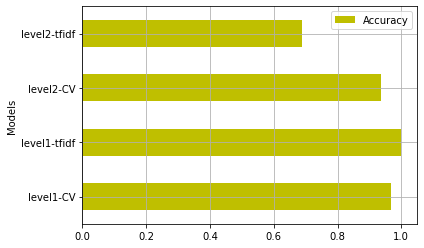

In [43]:
df.plot(x="Models", y="Accuracy", kind="barh", color = "y",grid=True)

In [44]:
import seaborn as sns

In [45]:
m=metric_l1p1.confusionMatrix().toArray()

<AxesSubplot:>

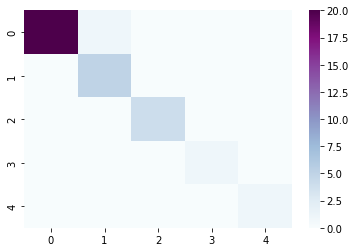

In [46]:
sns.heatmap(m,cmap='BuPu')

/tmp/ipykernel_52/2228950206.py:13: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(orientation='vertical')


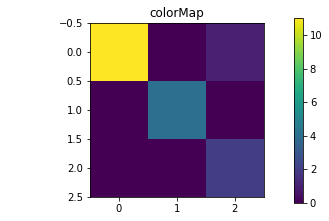

In [51]:
fig = plt.figure(figsize=(6, 3.2))

ax = fig.add_subplot(111)
ax.set_title('colorMap')
plt.imshow(m)
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')
plt.show()